# Control

These examples all cover dynamical simulation of systems related to device control. These examples use small systems, but note that the GPU will only provide an advantage for systems with total dimension of O(1000). 

## Gate Calibration

This example demonstrates how to perform pulse optimization.

In [1]:
import cudaq
from cudaq import boson, Schedule, ScalarOperator, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Sample device parameters
# Assuming a simple transmon device Hamiltonian in rotating frame.
detuning = 0.0  # Detuning of the drive; assuming resonant drive
anharmonicity = -340.0  # Anharmonicity
sigma = 0.01  # sigma of the Gaussian pulse
cutoff = 4.0 * sigma  # total length of drive pulse

# Dimensions of sub-system
# We model `transmon` as a 3-level system to account for leakage.
dimensions = {0: 3}

# Initial state of the system (ground state).
psi0 = cudaq.State.from_data(cp.array([1.0, 0.0, 0.0], dtype=cp.complex128))


def gaussian(t):
    """
    Gaussian shape with cutoff. Starts at t = 0, amplitude normalized to one
    """
    val = (np.exp(-((t-cutoff/2)/sigma)**2/2)-np.exp(-(cutoff/sigma)**2/8)) \
           / (1-np.exp(-(cutoff/sigma)**2/8))
    return val


def dgaussian(t):
    """
    Derivative of Gaussian. Starts at t = 0, amplitude normalized to one
    """
    return -(t - cutoff / 2) / sigma * np.exp(-(
        (t - cutoff / 2) / sigma)**2 / 2 + 0.5)


# Schedule of time steps.
steps = np.linspace(0.0, cutoff, 201)
schedule = Schedule(steps, ["t"])

# We optimize for a X(pi/2) rotation
target_state = np.array([1.0 / np.sqrt(2), -1j / np.sqrt(2), 0.0],
                        dtype=cp.complex128)


# Optimize the amplitude of the drive pulse (DRAG - Derivative Removal by Adiabatic Gate)
def cost_function(amps):
    amplitude = 100 * amps[0]
    drag_amp = 100 * amps[1]
    # Qubit Hamiltonian
    hamiltonian = detuning * boson.number(0) + (
        anharmonicity / 2) * boson.create(0) * boson.create(
            0) * boson.annihilate(0) * boson.annihilate(0)
    # Drive term
    hamiltonian += amplitude * ScalarOperator(gaussian) * (boson.create(0) +
                                                           boson.annihilate(0))

    # Drag term (leakage reduction)
    hamiltonian += 1j * drag_amp * ScalarOperator(dgaussian) * (
        boson.annihilate(0) - boson.create(0))

    # We optimize for a X(pi/2) rotation
    evolution_result = cudaq.evolve(hamiltonian,
                                    dimensions,
                                    schedule,
                                    psi0,
                                    observables=[],
                                    collapse_operators=[],
                                    store_intermediate_results=cudaq.IntermediateResultSave.NONE,
                                    integrator=ScipyZvodeIntegrator())
    final_state = evolution_result.final_state()

    overlap = np.abs(final_state.overlap(target_state))
    print(
        f"Gaussian amplitude = {amplitude}, derivative amplitude = {drag_amp}, Overlap: {overlap}"
    )
    return 1.0 - overlap


# Specify the optimizer
optimizer = cudaq.optimizers.NelderMead()
optimal_error, optimal_parameters = optimizer.optimize(dimensions=2,
                                                       function=cost_function)

print("optimal overlap =", 1.0 - optimal_error)
print("optimal parameters =", optimal_parameters)

Gaussian amplitude = 0.0, derivative amplitude = 0.0, Overlap: 0.7071067811865475
Gaussian amplitude = 157.07963267948966, derivative amplitude = 0.0, Overlap: 0.7678402941325417
Gaussian amplitude = 157.07963267948966, derivative amplitude = 157.07963267948966, Overlap: 0.6797941803182259
Gaussian amplitude = 0.0, derivative amplitude = -157.07963267948966, Overlap: 0.9296240579072232
Gaussian amplitude = -78.53981633974483, derivative amplitude = -314.1592653589793, Overlap: 0.7162211356808167
Gaussian amplitude = 157.07963267948966, derivative amplitude = -157.07963267948966, Overlap: 0.44596190760545296
Gaussian amplitude = 39.269908169872416, derivative amplitude = -39.269908169872416, Overlap: 0.9398996786747706
Gaussian amplitude = -117.80972450961724, derivative amplitude = -196.34954084936206, Overlap: 0.5878521963356885
Gaussian amplitude = 88.35729338221293, derivative amplitude = -49.087385212340514, Overlap: 0.6575502829271433
Gaussian amplitude = 98.17477042468103, deriva

## Pulse

This example demonstrates how a transmon qubit is driven by a pulse (modulated signal with a Gaussian envelop) in the lab frame.

Text(0.5, 1.0, 'Qubit State')

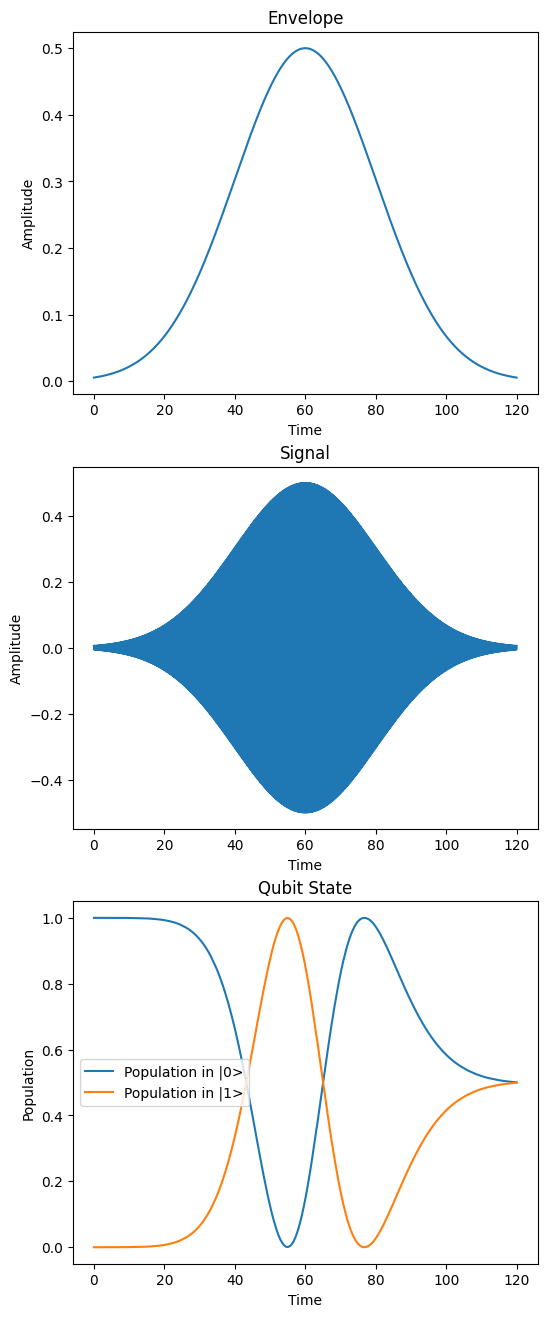

In [2]:
import cudaq
from cudaq import spin, boson, ScalarOperator, Schedule, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Device parameters
# Strength of the Rabi-rate in GHz.
rabi_rate = 0.1

# Frequency of the qubit transition in GHz.
omega = 5.0 * 2 * np.pi

# Define Gaussian envelope function to approximately implement a `rx(pi/2)` gate.
amplitude = 1. / 2.0  # Pi/2 rotation
sigma = 1.0 / rabi_rate / amplitude
pulse_duration = 6 * sigma


def gaussian(t, duration, amplitude, sigma):
    # Gaussian envelope function
    return amplitude * np.exp(-0.5 * (t - duration / 2)**2 / (sigma)**2)


def signal(t):
    # Modulated signal
    return np.cos(omega * t) * gaussian(t, pulse_duration, amplitude, sigma)


# Qubit Hamiltonian
hamiltonian = omega * spin.z(0) / 2
# Add modulated driving term to the Hamiltonian
hamiltonian += np.pi * rabi_rate * ScalarOperator(signal) * spin.x(0)

# Dimensions of sub-system. We only have a single degree of freedom of dimension 2 (two-level system).
dimensions = {0: 2}

# Initial state of the system (ground state).
psi0 = cudaq.State.from_data(cp.array([1.0, 0.0], dtype=cp.complex128))

# Schedule of time steps.
# Since this is a lab-frame simulation, the time step must be small to accurately capture the modulated signal.
dt = 1 / omega / 20
n_steps = int(np.ceil(pulse_duration / dt)) + 1
steps = np.linspace(0, pulse_duration, n_steps)
schedule = Schedule(steps, ["t"])

# Run the simulation.
# First, we run the simulation without any collapse operators (no decoherence).
evolution_result = cudaq.evolve(hamiltonian,
                                dimensions,
                                schedule,
                                psi0,
                                observables=[boson.number(0)],
                                collapse_operators=[],
                                store_intermediate_results=cudaq.IntermediateResultSave.EXPECTATION_VALUE,
                                integrator=ScipyZvodeIntegrator())

pop1 = [
    exp_vals[0].expectation()
    for exp_vals in evolution_result.expectation_values()
]
pop0 = [1.0 - x for x in pop1]
fig = plt.figure(figsize=(6, 16))
envelop = [gaussian(t, pulse_duration, amplitude, sigma) for t in steps]

plt.subplot(3, 1, 1)
plt.plot(steps, envelop)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Envelope")

modulated_signal = [
    np.cos(omega * t) * gaussian(t, pulse_duration, amplitude, sigma)
    for t in steps
]
plt.subplot(3, 1, 2)
plt.plot(steps, modulated_signal)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Signal")

plt.subplot(3, 1, 3)
plt.plot(steps, pop0)
plt.plot(steps, pop1)
plt.ylabel("Population")
plt.xlabel("Time")
plt.legend(("Population in |0>", "Population in |1>"))
plt.title("Qubit State")

## Qubit Control

This example simulates time evolution of a qubit (`transmon`) being driven close to resonance in the presence of noise (decoherence) and exhibiting Rabi oscillations.

Text(0.5, 1.0, 'With decoherence')

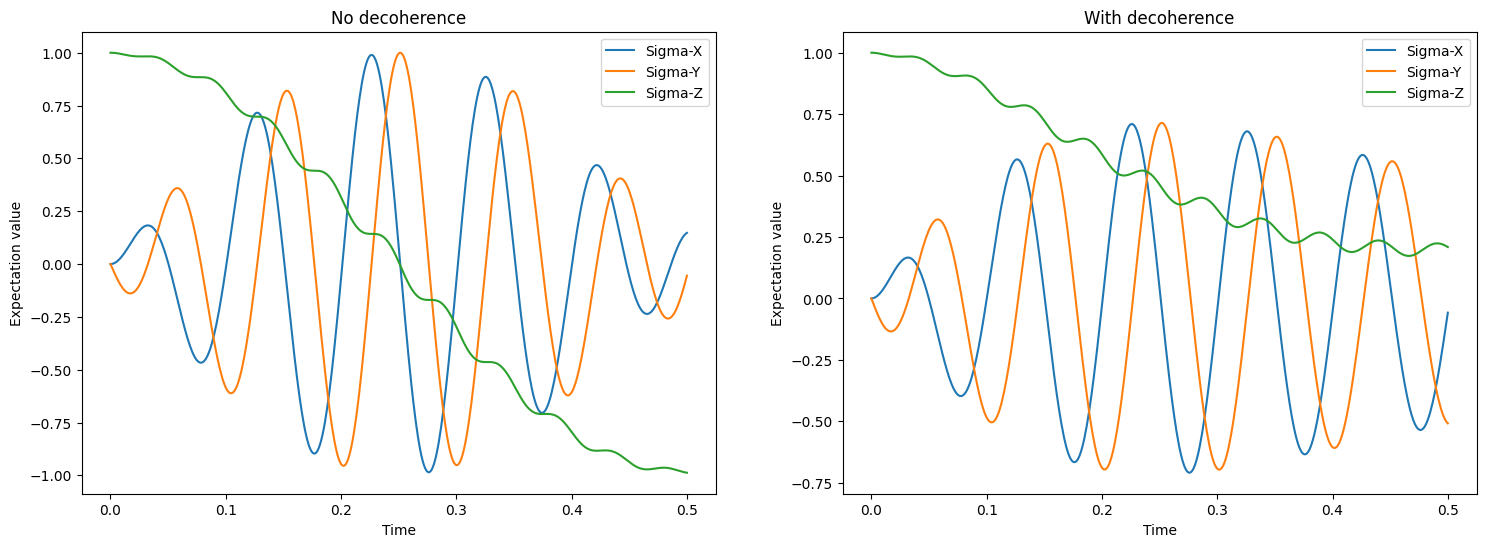

In [3]:
import cudaq
from cudaq import spin, ScalarOperator, Schedule, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Qubit Hamiltonian reference: https://qiskit-community.github.io/qiskit-dynamics/tutorials/Rabi_oscillations.html
# Device parameters
# Qubit resonant frequency
omega_z = 10.0 * 2 * np.pi
# Transverse term
omega_x = 2 * np.pi
# Harmonic driving frequency
# Note: we chose a frequency slightly different from the resonant frequency to demonstrate the off-resonance effect.
omega_drive = 0.99 * omega_z

# Qubit Hamiltonian
hamiltonian = 0.5 * omega_z * spin.z(0)
# Add modulated driving term to the Hamiltonian
hamiltonian += omega_x * ScalarOperator(
    lambda t: np.cos(omega_drive * t)) * spin.x(0)

# Dimensions of sub-system. We only have a single degree of freedom of dimension 2 (two-level system).
dimensions = {0: 2}

# Initial state of the system (ground state).
rho0 = cudaq.State.from_data(
    cp.array([[1.0, 0.0], [0.0, 0.0]], dtype=cp.complex128))

# Schedule of time steps.
t_final = np.pi / omega_x
dt = 2.0 * np.pi / omega_drive / 100
n_steps = int(np.ceil(t_final / dt)) + 1
steps = np.linspace(0, t_final, n_steps)
schedule = Schedule(steps, ["t"])

# Run the simulation.
# First, we run the simulation without any collapse operators (no decoherence).
evolution_result = cudaq.evolve(hamiltonian,
                                dimensions,
                                schedule,
                                rho0,
                                observables=[spin.x(0),
                                             spin.y(0),
                                             spin.z(0)],
                                collapse_operators=[],
                                store_intermediate_results=cudaq.IntermediateResultSave.EXPECTATION_VALUE,
                                integrator=ScipyZvodeIntegrator())

# Now, run the simulation with qubit decoherence
gamma_sm = 4.0
gamma_sz = 1.0
evolution_result_decay = cudaq.evolve(
    hamiltonian,
    dimensions,
    schedule,
    rho0,
    observables=[spin.x(0), spin.y(0), spin.z(0)],
    collapse_operators=[
        np.sqrt(gamma_sm) * spin.plus(0),
        np.sqrt(gamma_sz) * spin.z(0)
    ],
    store_intermediate_results=cudaq.IntermediateResultSave.EXPECTATION_VALUE,
    integrator=ScipyZvodeIntegrator())

get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]
ideal_results = [
    get_result(0, evolution_result),
    get_result(1, evolution_result),
    get_result(2, evolution_result)
]
decoherence_results = [
    get_result(0, evolution_result_decay),
    get_result(1, evolution_result_decay),
    get_result(2, evolution_result_decay)
]

fig = plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(steps, ideal_results[0])
plt.plot(steps, ideal_results[1])
plt.plot(steps, ideal_results[2])
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Sigma-X", "Sigma-Y", "Sigma-Z"))
plt.title("No decoherence")

plt.subplot(1, 2, 2)
plt.plot(steps, decoherence_results[0])
plt.plot(steps, decoherence_results[1])
plt.plot(steps, decoherence_results[2])
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Sigma-X", "Sigma-Y", "Sigma-Z"))
plt.title("With decoherence")


## Qubit Dynamics 

Text(0.5, 1.0, 'With decay')

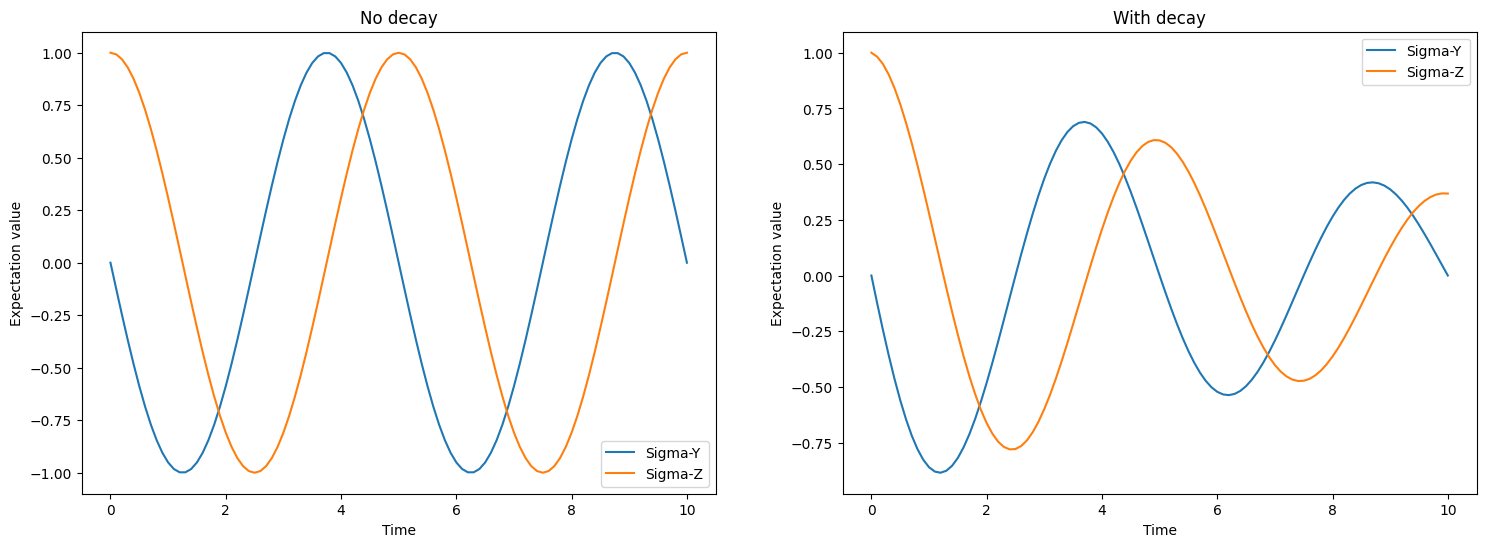

In [4]:
import cudaq
from cudaq import spin, Schedule, RungeKuttaIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Qubit Hamiltonian
hamiltonian = 2 * np.pi * 0.1 * spin.x(0)

# Dimensions of sub-system. We only have a single degree of freedom of dimension 2 (two-level system).
dimensions = {0: 2}

# Initial state of the system (ground state).
rho0 = cudaq.State.from_data(
    cp.array([[1.0, 0.0], [0.0, 0.0]], dtype=cp.complex128))

# Schedule of time steps.
steps = np.linspace(0, 10, 101)
schedule = Schedule(steps, ["time"])

# Run the simulation.
# First, we run the simulation without any collapse operators (ideal).
evolution_result = cudaq.evolve(hamiltonian,
                                dimensions,
                                schedule,
                                rho0,
                                observables=[spin.y(0), spin.z(0)],
                                collapse_operators=[],
                                store_intermediate_results=cudaq.IntermediateResultSave.EXPECTATION_VALUE,
                                integrator=RungeKuttaIntegrator())

# Now, run the simulation with qubit decaying due to the presence of a collapse operator.
evolution_result_decay = cudaq.evolve(
    hamiltonian,
    dimensions,
    schedule,
    rho0,
    observables=[spin.y(0), spin.z(0)],
    collapse_operators=[np.sqrt(0.05) * spin.x(0)],
    store_intermediate_results=cudaq.IntermediateResultSave.EXPECTATION_VALUE,
    integrator=RungeKuttaIntegrator())

get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]
ideal_results = [
    get_result(0, evolution_result),
    get_result(1, evolution_result)
]
decay_results = [
    get_result(0, evolution_result_decay),
    get_result(1, evolution_result_decay)
]

fig = plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(steps, ideal_results[0])
plt.plot(steps, ideal_results[1])
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Sigma-Y", "Sigma-Z"))
plt.title("No decay")

plt.subplot(1, 2, 2)
plt.plot(steps, decay_results[0])
plt.plot(steps, decay_results[1])
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Sigma-Y", "Sigma-Z"))
plt.title("With decay")


## Landau-Zenner


This example simulates the so-called Landau–Zener transition: given a time-dependent Hamiltonian such that the energy separationof the two states is a linear function of time, an analytical formula exists to calculate the probability of finding the system in the excited state after the transition.

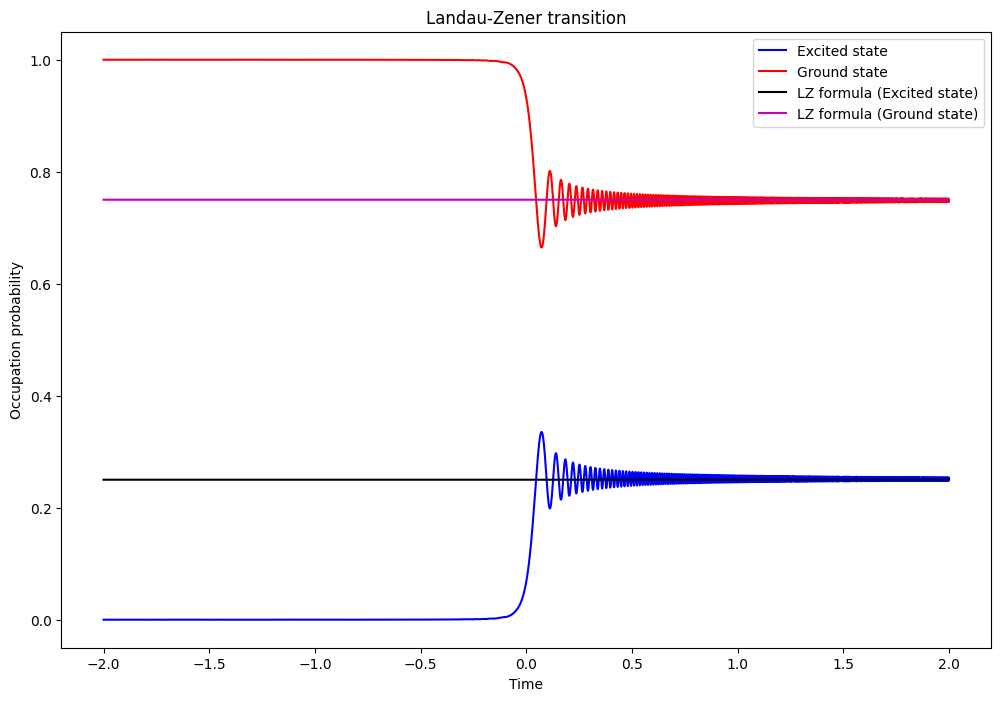

In [5]:
import cudaq
from cudaq import spin, boson, ScalarOperator, Schedule, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt

# References:
# - https://en.wikipedia.org/wiki/Landau%E2%80%93Zener_formula
# - `The Landau-Zener formula made simple`, `Eric P Glasbrenner and Wolfgang P Schleich 2023 J. Phys. B: At. Mol. Opt. Phys. 56 104001`
# - QuTiP notebook: https://github.com/qutip/qutip-notebooks/blob/master/examples/landau-zener.ipynb

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Define some shorthand operators
sx = spin.x(0)
sz = spin.z(0)
sm = boson.annihilate(0)
sm_dag = boson.create(0)

# Dimensions of sub-system. We only have a single degree of freedom of dimension 2 (two-level system).
dimensions = {0: 2}

# Landau–Zener Hamiltonian:
# `[[-alpha*t, g], [g, alpha*t]] = g * pauli_x - alpha * t * pauli_z`
g = 2 * np.pi
# Analytical equation:
# `P(0) = exp(-pi * g ^ 2/ alpha)`
# The target ground state probability that we want to achieve
target_p0 = 0.75
# Compute `alpha` parameter:
alpha = (-np.pi * g**2) / np.log(target_p0)

# Hamiltonian
hamiltonian = g * sx - alpha * ScalarOperator(lambda t: t) * sz

# Initial state of the system (ground state)
psi0 = cudaq.State.from_data(cp.array([1.0, 0.0], dtype=cp.complex128))

# Schedule of time steps (simulating a long time range)
steps = np.linspace(-2.0, 2.0, 5000)
schedule = Schedule(steps, ["t"])

# Run the simulation.
evolution_result = cudaq.evolve(hamiltonian,
                                dimensions,
                                schedule,
                                psi0,
                                observables=[boson.number(0)],
                                collapse_operators=[],
                                store_intermediate_results=cudaq.IntermediateResultSave.EXPECTATION_VALUE,
                                integrator=ScipyZvodeIntegrator())

prob1 = [
    exp_vals[0].expectation()
    for exp_vals in evolution_result.expectation_values()
]

prob0 = [1 - val for val in prob1]
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(steps, prob1, 'b', steps, prob0, 'r')
ax.plot(steps, (1.0 - target_p0) * np.ones(np.shape(steps)), 'k')
ax.plot(steps, target_p0 * np.ones(np.shape(steps)), 'm')
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
ax.set_title("Landau-Zener transition")
ax.legend(("Excited state", "Ground state", "LZ formula (Excited state)",
           "LZ formula (Ground state)"),
          loc=0)
